# 삼성 DS-KAIST AI Expert 프로그램
## Week 3: 신경망 기초, 다층신경망

실습 일시: 2019년 7월 15일 (월), 13:30 - 17:30

담당 조교: 정종헌 (jongheonj@kaist.ac.kr)

In [1]:
# 실습에서 사용할 모듈을 import 합니다.

# IPython 상에서 matplotlib 라이브러리가 
# 별도의 창 없이 즉시 plot을 출력할 수 있도록 설정을 변경합니다.
%matplotlib inline

import functools
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K

# "즉시 실행" (eager execution) 기능을 활성화합니다.
# 즉시 실행 활성화로 TensorFlow를 대화형 프론트엔드(frontend)에 가깝게 만들어 줍니다.
# 해당 기능은 TensorFlow 2.0 부터는 기본적으로 활성화됩니다. 
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))
print(tf.__version__)

Eager execution: True
1.14.0


In [2]:
# 실습 과정에서 사용되는 도움함수를 정의합니다. 

def parse(line):
    """색깔 데이터셋의 각 라인을 파싱함"""

    # 데이터셋의 각 라인은 쉼표로(,) 구분되어 있고, 다음과 같은 포맷을 가집니다.
    #    color_name, r, g, b
    # 따라서, `items` 는 [color_name, r, g, b]의 형태를 가지는 list입니다.
    items = tf.string_split([line], ",").values
    
    # 불러온 데이터셋의 (r, g, b)는 0~255 사이의 값을 가집니다.
    # 여기서는 각 수치가 0~1 사이의 값을 가지도록 전처리합니다.
    rgb = tf.string_to_number(items[1:], out_type=tf.float32) / 255.
    
    # color_name은 색깔의 이름을 나타내는 string입니다.
    # string의 각 character를 숫자로 변환하고, 이를 one-hot 인코딩하여 전처리합니다.
    color_name = items[0]
    chars = tf.one_hot(tf.decode_raw(color_name, tf.uint8), depth=256)
    
    # color_name의 string 길이도 전처리로 계산하여 함께 전달합니다.
    length = tf.cast(tf.shape(chars)[0], dtype=tf.int64)
    
    return rgb, chars, length

def load_dataset(data_path, batch_size):
    # 효과적인 학습 구성을 위해, .csv 형태의 데이터셋을 tf.data.Dataset으로 변환합니다:
    #   1. 첫 헤더 줄을 생략합니다; (.skip(1))
    #   2. 각 줄에 대해 `parse()` 함수를 적용합니다; (.map(parse))
    #   3. 데이터를 무작위로 셔플합니다; (.shuffle(...))
    #   3. 데이터를 배치 형태로 묶습니다 (.padded_batch(...)).
    dataset = tf.data.TextLineDataset(data_path).skip(1).map(parse)
    dataset = dataset.shuffle(10000).padded_batch(batch_size, padded_shapes=([None], [None, None], []))
    return dataset

In [3]:
class RNNColorbot(tf.keras.Model):
    """Multi-layer (LSTM) RNN that regresses on real-valued vector labels."""

    def __init__(self, rnn_cell_sizes):
        """Constructs an RNNColorbot.

        Args:
            rnn_cell_sizes: list of integers denoting the size of each LSTM cell in
                the RNN; rnn_cell_sizes[i] is the size of the i-th layer cell
        """
        super(RNNColorbot, self).__init__()

        self.cells = [L.LSTMCell(size, dropout=0.5) for size in rnn_cell_sizes]
        self.relu = L.Dense(3, activation=tf.nn.relu)

    def call(self, inputs, training):
        """Implements the RNN logic and prediction generation.

        Args:
            inputs: A tuple (chars, sequence_length), where chars is a batch of
                one-hot encoded color names represented as a Tensor with dimensions
                [batch_size, time_steps, 256] and sequence_length holds the length
                of each character sequence (color name) as a Tensor with dimension
                [batch_size].

        Returns:
            A tensor of dimension [batch_size, label_dimension] that is produced by
            passing chars through a multi-layer RNN and applying a ReLU to the final
            hidden state.
        """
        (chars, sequence_length) = inputs
        
        # Transpose the first and second dimensions so that chars is of shape
        # [time_steps, batch_size, dimension].
        chars = tf.transpose(chars, [1, 0, 2])
        
        # The outer loop cycles through the layers of the RNN; 
        # the inner loop executes the time steps for a particular layer.
        batch_size = int(chars.shape[1])
        for l in range(len(self.cells)):
            cell = self.cells[l]
            outputs = []
            state = cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)
            
            # Unstack the inputs to obtain a list of batches, one for each time step.
            chars = tf.unstack(chars, axis=0)
            
            for ch in chars:
                cell.reset_dropout_mask()
                output, state = cell(ch, state, training)
                outputs.append(output)
                
            # The outputs of this layer are the inputs of the subsequent layer.
            chars = tf.stack(outputs, axis=0)
            
        # Extract the correct output (i.e., hidden state) for each example. All the
        # character sequences in this batch were padded to the same fixed length so
        # that they could be easily fed through the above RNN loop. The
        # `sequence_length` vector tells us the true lengths of the character
        # sequences, letting us obtain for each sequence the hidden state that was
        # generated by its non-padding characters.
        batch_range = [i for i in range(batch_size)]
        indices = tf.stack([sequence_length - 1, batch_range], axis=1)
        hidden_states = tf.gather_nd(chars, indices)
        output = self.relu(hidden_states)
        return output

In [4]:
# 학습하고자 하는 모델을 구성합니다. 
# 여기서는, 2-레이어의 LSTM 셀을 사용하는 RNN을 구성할 것입니다.
model = RNNColorbot(rnn_cell_sizes=[256, 128])

# 훈련 데이터셋과 테스트 데이터셋을 로드합니다.
train_ds = load_dataset('resource/rnn_train.csv', batch_size=64)
test_ds = load_dataset('resource/rnn_test.csv', batch_size=64)

# Adam 알고리즘을 통해 최적화를 수행하고, learning rate를 0.01로 설정합니다.
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)

# 최적화하고자 하는 loss를 정의합니다.
def loss_object(labels, predictions):
    return tf.reduce_mean(tf.math.squared_difference(predictions, labels))

# 학습 도중 계산되는 성능 측정값을 계산할 수 있는 연산자를 생성합니다.
train_loss = keras.metrics.Mean("train_loss")
test_loss = keras.metrics.Mean("test_loss")

In [5]:
def train_step(model, labels, chars, sequence_length):
    with tf.GradientTape() as tape:
        predictions = model((chars, sequence_length), training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)

def test_step(model, labels, chars, sequence_length):
    predictions = model((chars, sequence_length), training=False)
    test_loss(loss_object(labels, predictions))

In [6]:
# 전체 데이터셋을 20번 재방문 할 때까지 훈련을 반복합니다.
EPOCHS = 100

for epoch in range(EPOCHS):
    print(f"===== Epoch {epoch+1:d} =====")
    for labels, chars, sequence_length in train_ds:
        train_step(model, labels, chars, sequence_length)
    print(f"[TRAIN] Avg. Loss: {train_loss.result():.6f}")
    
    for labels, chars, sequence_length in test_ds:
        test_step(model, labels, chars, sequence_length)
    print(f"[TEST] Avg. Loss: {test_loss.result():.4f}")
    
    if np.abs(train_loss.result()-test_loss.result()) < 1e-3:
        break

print("ColorBot is ready to generate colors!")

===== Epoch 1 =====


W0723 13:47:29.050265 10628 deprecation.py:323] From c:\users\ironm\tf-nightly\lib\site-packages\tensorflow\python\ops\math_grad.py:1220: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


[TRAIN] Avg. Loss: 0.186505
[TEST] Avg. Loss: 0.0942
===== Epoch 2 =====
[TRAIN] Avg. Loss: 0.139141
[TEST] Avg. Loss: 0.0852
===== Epoch 3 =====
[TRAIN] Avg. Loss: 0.121067
[TEST] Avg. Loss: 0.0825
===== Epoch 4 =====
[TRAIN] Avg. Loss: 0.111197
[TEST] Avg. Loss: 0.0802
===== Epoch 5 =====
[TRAIN] Avg. Loss: 0.104711
[TEST] Avg. Loss: 0.0785
===== Epoch 6 =====
[TRAIN] Avg. Loss: 0.100164
[TEST] Avg. Loss: 0.0769
===== Epoch 7 =====
[TRAIN] Avg. Loss: 0.096768
[TEST] Avg. Loss: 0.0762
===== Epoch 8 =====
[TRAIN] Avg. Loss: 0.093798
[TEST] Avg. Loss: 0.0751
===== Epoch 9 =====
[TRAIN] Avg. Loss: 0.091712
[TEST] Avg. Loss: 0.0745
===== Epoch 10 =====
[TRAIN] Avg. Loss: 0.089896
[TEST] Avg. Loss: 0.0737
===== Epoch 11 =====
[TRAIN] Avg. Loss: 0.088293
[TEST] Avg. Loss: 0.0729
===== Epoch 12 =====
[TRAIN] Avg. Loss: 0.086678
[TEST] Avg. Loss: 0.0722
===== Epoch 13 =====
[TRAIN] Avg. Loss: 0.085281
[TEST] Avg. Loss: 0.0713
===== Epoch 14 =====
[TRAIN] Avg. Loss: 0.084020
[TEST] Avg. Loss: 

In [7]:
def colorbot(color_name):
    _, chars, length = parse(color_name)
    chars = tf.expand_dims(chars, 0)
    length = tf.expand_dims(length, 0)
    preds = tf.unstack(model((chars, length), training=False)[0])

    # 학습 모델이 마지막에 ReLU activation을 사용하기 때문에, 
    # 예측값이 1이 넘을 수도 있습니다. 
    # 예측된 값이 0~1 사이의 값을 가지도록 결과값을 clipping 합니다.
    clipped_preds = tuple(min(float(p), 1.0) for p in preds)
    rgb = tuple(int(p * 255) for p in clipped_preds)
    print("Predicted RGB values:", rgb)
    plt.imshow([[clipped_preds]])
    plt.title(color_name)
    plt.show()

Predicted RGB values: (229, 216, 62)


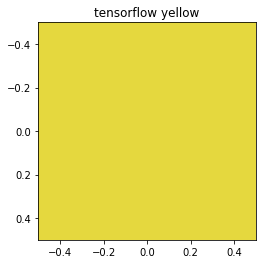

In [8]:
colorbot('tensorflow yellow')

Predicted RGB values: (208, 0, 16)


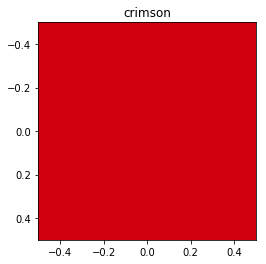

In [9]:
colorbot('crimson')

Predicted RGB values: (247, 255, 255)


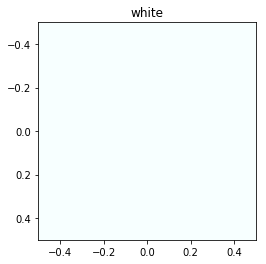

In [10]:
colorbot('white')

Predicted RGB values: (0, 26, 31)


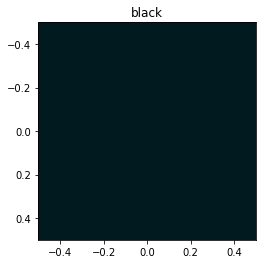

In [11]:
colorbot('black')

Predicted RGB values: (193, 62, 59)


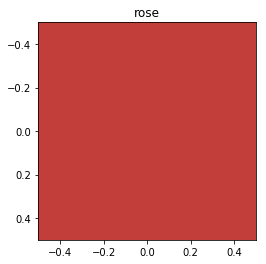

In [12]:
colorbot('rose')

Predicted RGB values: (82, 209, 226)


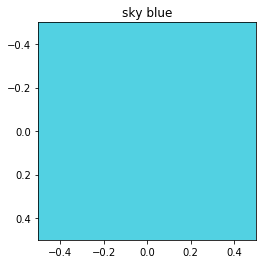

In [13]:
colorbot('sky blue')